In [1]:
# -*- coding: utf-8 -*-
"""
Modified on Sun Oct 5 12:59:16 2025

@author:        Alaina Mahalanobis
@Modified by":  Milad Khaki

"""

# CORRECT EVOKED POTENTIAL PLOTTING CODE

import numpy as np
import pyedflib
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from mne.filter import filter_data, notch_filter
import pandas as pd


from ccep_lib import decode_events_rev1,decode_events_rev2, detrend_cubic, get_channel_summary


In [2]:
# Parameters

current = '3'
subject_id = "P153"
session_fold = "ses-001"
session_id   = "ses-001"
session_name_trailer = "_reduced_InsulaStim2"
run = 1

stimulated_channel = "LPIn1"

evoked_channel = "LPHc2"

en_band_pass_filter = False
en_notch = False
en_detrend = False
en_median = False
med_val = 19

plot_psd = False

read_events_edf0_tsv1 = False

# Initialize list to store all events
all_events = []
current_pair = None

In [3]:
# # if 'edf_file' not in locals():
main_folder = f"./data/sub-{subject_id}/{session_fold}"
edf_path = main_folder + "/" + f"sub-{subject_id[1:]}_{session_id}_task-ccep_run-{run:02.0f}_ieeg{session_name_trailer}.edf"
edf_file = pyedflib.EdfReader(edf_path)



if read_events_edf0_tsv1 == False:
    # Get annotations (events)
    annotations = edf_file.readAnnotations()
    annot_labels = annotations[2]
    annot_timestamps = annotations[0] 
    
else:
        # Read events from TSV instead of EDF annotations
    tsv_file = (
        main_folder
        + f"/sub-{subject_id[1:]}_{session_id}_task-ccep_run-{run:02.0f}_events{session_name_trailer}.tsv"
    )


    events_df = pd.read_csv(tsv_file, sep="\t")

    annot_labels = []
    annot_timestamps = []
    all_events = []
    for _, row in events_df.iterrows():
        timestamp = row["onset"]       # time in seconds
        label = row["event"]      # event description
        # If you encode the pair in trial_type like "Closed relay to X and Y"
        annot_labels.append(label)
        annot_timestamps.append(timestamp)


filtered_events = []
event_decode_revision = 0

try:
    filtered_events = decode_events_rev1(annot_timestamps, annot_labels, current, stimulated_channel)
    if filtered_events:
        event_decode_revision = 1
except Exception as e:
    print(e)
    pass

if not filtered_events:
    try:
        filtered_events = decode_events_rev2(annot_timestamps, annot_labels, current, stimulated_channel)
        if filtered_events:
            event_decode_revision = 2
    except Exception as e:
        print(e)
        pass

if event_decode_revision == 0:
    raise(Exception("Couldn't find any method to decode the events, either issue with event text format or channel selection"))
print(f"Using event decode revision {event_decode_revision}")


# Ensure only the first event is selected
if len(filtered_events) > 1:
    filtered_events = [filtered_events[0]]

# Output the filtered event (timestamp, label, and stimulated channel)
for event in filtered_events:
    print(
        f"Timestamp: {event[0]}, Event Label: {event[1]}, "
        f"Stimulated Channel: {event[2][0]}"
    )

# Get channel labels and indices
channel_labels = edf_file.getSignalLabels()
try:
    stimulated_channel_index = channel_labels.index(stimulated_channel)
except Exception as e:
    print("Electrodes :",get_channel_summary(channel_labels))
    raise(e)
print("Electrodes :",get_channel_summary(channel_labels))

evoked_channel_index = channel_labels.index(evoked_channel)

# Extract the sampling rate
sampling_rate = edf_file.getSampleFrequency(stimulated_channel_index)

# Get the timestamp of the first filtered event
event_timestamp = filtered_events[0][0]

# Define indices for the segment around the event (10 seconds total)
start_index = np.floor((event_timestamp -2)* sampling_rate)
end_index = start_index + int(np.ceil(10 * sampling_rate))
sig_len = (end_index-start_index)/sampling_rate
start_index = int(max(0, start_index))

print(f"start index {start_index} end index {end_index}")

# Read the signals for both channels (stimulated and evoked)
all_sig_st = edf_file.readSignal(stimulated_channel_index)
all_sig_ev = edf_file.readSignal(evoked_channel_index)

end_index = int(np.nanmin([end_index,len(all_sig_st)]))

Using event decode revision 1
Timestamp: 39.6860351, Event Label: 3, Stimulated Channel: LPIn1
Electrodes : {'LAIn', 'LPCg', 'LACg', 'LAm', 'LMiIn', 'RPHc', 'LOFr', 'ECG', 'LAHc', 'RAHc', 'LTePo', 'LLg', 'LPHc', 'LPIn'}
start index 77180 end index 97660.0


In [4]:
print(f"{edf_path}")
edf_file.close()


./data/sub-P153/ses-001/sub-153_ses-001_task-ccep_run-01_ieeg_reduced_InsulaStim2.edf


In [5]:
if en_band_pass_filter == True:
    all_sig_st = filter_data(
        all_sig_st,
        sfreq=sampling_rate,
        l_freq=1,
        h_freq=300,
        # filter_length="1s",     # number of samples (can also be "10s", "0.5s" string)
        fir_design='firwin',     # default design
        fir_window='hamming',    # common choice
        verbose=False,
    )

    # Example: set filter length explicitly to 661 samples (~0.5s if fs=1300 Hz)
    all_sig_ev = filter_data(
        all_sig_ev,
        sfreq=sampling_rate,
        l_freq=1,
        h_freq=300,
        # filter_length=401,     # number of samples (can also be "10s", "0.5s" string)
        fir_design='firwin',     # default design
        fir_window='hamming',    # common choice
        verbose=False,
    )

line_freq = 60.0  # or 50.0 depending on your country
max_harm = sampling_rate / 3.0
notch_freqs = [line_freq] #np.arange(line_freq, max_harm, line_freq)
all_sig_ev_org = all_sig_ev

if en_notch == True:
    all_sig_st = notch_filter(
        all_sig_st,
        Fs=sampling_rate,
        freqs=notch_freqs,
        notch_widths=4.0,   # width in Hz (can tighten if needed)
        fir_design='firwin',
        verbose=False,
    )
    all_sig_ev = notch_filter(
        all_sig_ev,
        Fs=sampling_rate,
        freqs=notch_freqs,
        notch_widths=4.0,   # width in Hz (can tighten if needed)
        fir_design='firwin',
        verbose=False,
    )

stimulated_signal = all_sig_st[start_index:end_index]
evoked_signal = all_sig_ev[start_index:end_index]

In [6]:
# Peak detection parameters
min_peak_height_stimulated = (
    np.nanmean(stimulated_signal) + np.nanstd(stimulated_signal)
)
min_peak_distance = int(0.9 * sampling_rate)
min_peak_height_evoked = np.nanmean(evoked_signal) + np.nanstd(evoked_signal)

# Detect peaks
stimulated_peaks = find_peaks(
    stimulated_signal, height=min_peak_height_stimulated, distance=min_peak_distance
)[0]
evoked_peaks = find_peaks(
    evoked_signal, height=min_peak_height_evoked, distance=min_peak_distance
)[0]

# Segment extraction and baseline correction
segments = []
all_raw_segments = []  # To store non-normalized segments for overlapping plot
segment_length = int(0.250 * sampling_rate)  # 250 ms (for 200 ms window after peak)
baseline_start = -25  # ms
baseline_end = -5  # ms

jitter_ms = 3  # +/- jitter in ms
jitter_samples = int((jitter_ms / 1000.0) * sampling_rate)

for peak in evoked_peaks:
    # Only consider peaks after 20 ms
    if peak < int(0.02 * sampling_rate):
        continue

    # add jitter
    jitter = 0  # np.random.randint(-jitter_samples, jitter_samples+1)

    start_sample = peak + jitter + int(-0.05 * sampling_rate)   # -50 ms + jitter
    end_sample = peak + jitter + int(0.2 * sampling_rate)       # +200 ms + jitter

    # clamp to bounds
    start_sample = int(max(start_sample, 0))
    end_sample = int(min(end_sample, len(evoked_signal)))

    detrend_shoulder = int(0.1*sampling_rate)
    if en_detrend == True: 
        if start_sample >= detrend_shoulder:
            evoked_tmp = evoked_signal[start_sample - detrend_shoulder:start_sample + segment_length + detrend_shoulder]
        else:
            evoked_tmp = evoked_signal[start_sample:start_sample + segment_length]
            
        evoked_tmp, trend, coeffs = detrend_cubic(evoked_tmp, max_curvature=1e-2)
        segment = evoked_tmp[detrend_shoulder+1:segment_length + detrend_shoulder]

    else:
        segment = evoked_signal[start_sample:start_sample + segment_length]
    
    # if en_detrend == True:
        # normalized_segment = signal.detrend(normalized_segment)

    raw_segment = stimulated_signal[start_sample:start_sample + segment_length]

    if len(segment) < segment_length:
        segment = np.pad(
            segment, (0, segment_length - len(segment)), 'constant'
        )
    if len(raw_segment) < segment_length:
        raw_segment = np.pad(
            raw_segment, (0, segment_length - len(raw_segment)), 'constant'
        )

    all_raw_segments.append(raw_segment)

    # Time vector always matches
    segment_times = np.linspace(-50, 200, segment_length)

    # Baseline correction: Mask for baseline (-25ms to -5ms)
    baseline_mask = (segment_times >= baseline_start) & (segment_times <= baseline_end)
    baseline_values = segment[baseline_mask]
    baseline_mean = np.nanmean(baseline_values)
    baseline_std = np.nanstd(baseline_values)

    from scipy.signal import medfilt

    # Normalize the segment
    normalized_segment = (segment - baseline_mean) / baseline_std
    window_size = med_val  # try 5, 7, or 11 depending on sampling rate and desired smoothness
    if en_median == True:
        normalized_segment = medfilt(normalized_segment, kernel_size=window_size)
    # normalized_segment = moving_average(normalized_segment, window_size=5)


    segments.append((segment_times, normalized_segment))

# evoked_time_vector = np.linspace(-50, 200, segments[1][1])  # From -50 ms to 200 ms

# Calculate the average evoked potential
average_evoked = (
    np.nanmean([(segment[1]) for segment in segments], axis=0) if segments else None
)
edf_file.close()

pks pos  [35]
The time to the first peak is 37.57 ms.
Value of peak 8.345


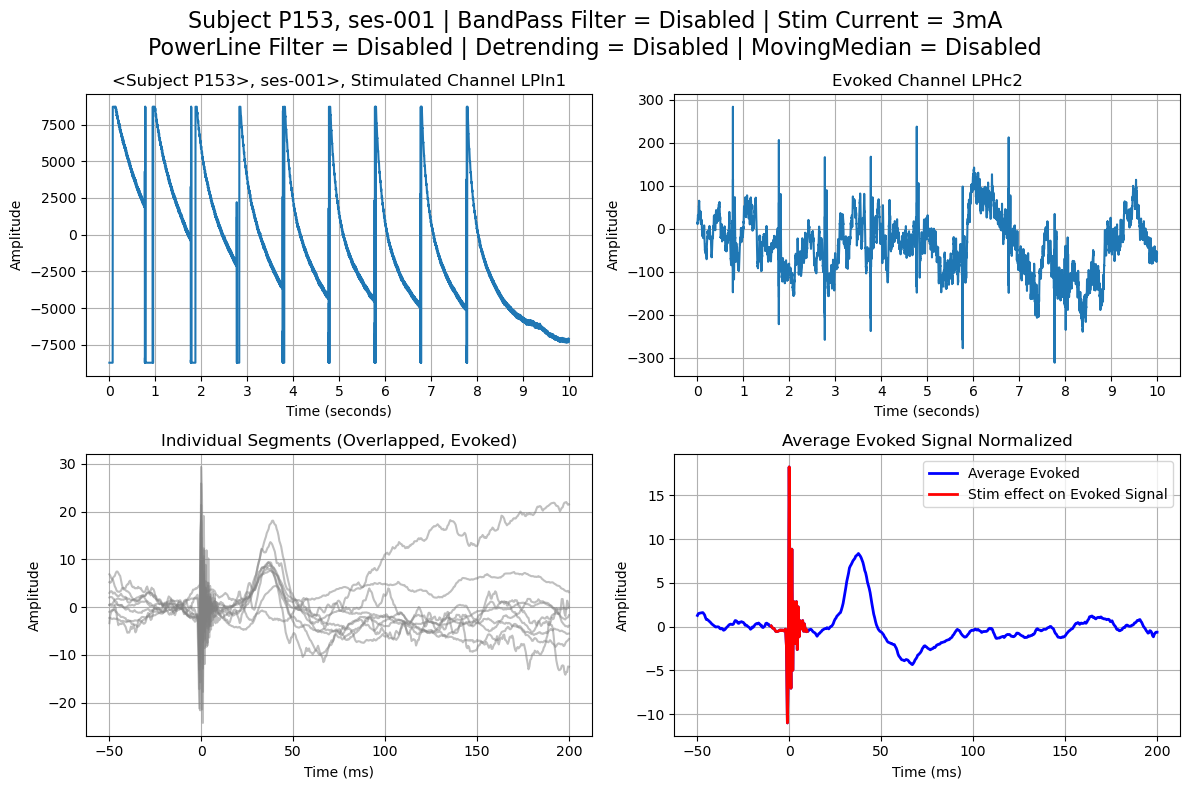

In [7]:
if average_evoked is not None:

    # Define time vector for the average evoked potential
    evoked_time_vector = np.linspace(-50, 200, len(average_evoked))  # -50 to 200 ms

    # Veit: work on positive peaks in 20–190 ms
    search_mask = (evoked_time_vector >= 20) & (evoked_time_vector <= 190)
    y = average_evoked

    # If your convention hasn’t been enforced earlier, enforce “max positive”:
    # (Optional if you only detect positive peaks below)
    # Flip based on the detected peak’s sign, not abs-max
    pks_pos, _ = find_peaks(y[search_mask], prominence=7)
    print("pks pos ", pks_pos)

    if len(pks_pos) == 0:
        # try negative peaks by flipping once
        y = -y
        pks_pos, _ = find_peaks(y[search_mask], prominence=7)
        print("flipped")

    if len(pks_pos) == 0:
        print("No significant peak between 20–190 ms on the averaged trace.")
        time_to_first_peak = None
        peak_value = None
    else:
        i0 = np.where(search_mask)[0][0]
        first_peak_index = i0 + pks_pos[0]
        time_to_first_peak = evoked_time_vector[first_peak_index]
        peak_value = y[first_peak_index]
        print(f"The time to the first peak is {time_to_first_peak:.2f} ms.")
        print(f"Value of peak {peak_value:.3f}")

    # Plot 1: Stimulated signal (all 10 seconds)
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    time_stimulated = np.linspace(0, sig_len, len(stimulated_signal))
    plt.plot(time_stimulated, stimulated_signal)
    plt.xticks(ticks=range(0,int(sig_len+2)))
    plt.title(
        f"<Subject {subject_id}>, {session_id}>, Stimulated Channel {stimulated_channel}"
    )
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.xlim(-0.5,sig_len+0.5)

    # Plot 2: Evoked signal (all 10 seconds)
    plt.subplot(2, 2, 2)
    time_evoked = np.linspace(0, sig_len, len(evoked_signal))
    plt.plot(time_evoked, evoked_signal)
    plt.title(f"Evoked Channel {evoked_channel}")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.xticks(ticks=range(0,int(sig_len+2)))
    plt.xlim(-0.5,sig_len+0.5)


    # Plot 3: Individual segments overlapped (after normalization)
    plt.subplot(2, 2, 3)
    for segment in segments:
        segment_time = np.linspace(-50, 200, len(segment[0]))  # -50 ms to 200 ms
        plt.plot(segment_time, (segment[1]), color='gray', alpha=0.5)
    plt.title("Individual Segments (Overlapped, Evoked)")
    plt.xlabel("Time (ms)")
    plt.ylabel("Amplitude")
    plt.grid(True)

    # Plot 4: Average evoked signal
    plt.subplot(2, 2, 4)
    if average_evoked is not None:
        plt.plot(
            evoked_time_vector, y, label='Average Evoked', color='blue', linewidth=2
        )
        
        sel_ev_mask = (evoked_time_vector > -10) & (evoked_time_vector < 10)
        sel_not_stim = (evoked_time_vector < -8 ) | (evoked_time_vector > 8)

        plt.plot(
            evoked_time_vector[sel_ev_mask], y[sel_ev_mask], label='Stim effect on Evoked Signal', color='red', linewidth=2
        )
        plt.title("Average Evoked Signal Normalized")
        plt.xlabel("Time (ms)")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid(True)
        # plt.ylim(np.nanmin(y[sel_not_stim])-1, np.nanmax(y[sel_not_stim])*1.1)

    title_text = f"Subject {subject_id}, {session_id} | BandPass Filter = {'Enabled' if en_band_pass_filter == True else 'Disabled'} | Stim Current = {current}mA\n" + \
            f"PowerLine Filter = {'Enabled' if en_notch == True else 'Disabled'} | Detrending = {'Enabled' if en_detrend == True else 'Disabled'} | " + \
            f"MovingMedian = {f'Enabled + med_window = {med_val}' if en_median == True else 'Disabled'}"
    plt.suptitle(
        title_text,
        fontsize=16,
        y=0.98   # moves the title upward so it doesn’t overlap with subplots
    )

    plt.tight_layout()
    #plt.savefig(
    #    f"d:/CCEP_CodeReview/{subject_id}_S{session_id[4:]}_ccep_{stimulated_channel}_evoked_"
    #    f"{evoked_channel}_{current}mA.png",
    #    format='png',
    #    dpi=300,
    #)
    plt.show()

else:
    print("No segments found for evoked potential.")